# Тeматическое моделирование

В этом ноутбуке я покажу, как работает тематическое моделирование (topic modeling) на примере корпуса новостей с сайта Lenta.ru.

**Что это такое:**
"Тематическое моделирование — способ построения модели коллекции текстовых документов, которая определяет, к каким темам относится каждый из документов" [Википедия](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)

**Зачем?**
Тематическое моделирование позволяет автоматически выделить основные темы в корпусе текстов (наборе документов); ключевые слова, соответствующие каждой теме, и распределение тем над документами. Т.е. для каждого документа будет получен набор чисел, насколько данный документ принадлежит той или иной теме. 

В этом ноутбуке я буду использовать открытый датасет, который состоит из новостей с сайта Lenta.ru. Если хотите самостоятельно выполнить пример, то скачайте этот [датасет](https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2) и распакуйте его в папку с этой тетрадкой.

Существует несколько алгоритмов для тематического моделирования. Мы рассмотрим один из самых базовых - LDA (Latent Dirichle Allocation). А более продвинутые алгоритмы ищете на 

In [1]:
import pandas as pd

import json

import numpy as np

import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# EDA

In [2]:
df = pd.read_csv("./lenta-ru-news.csv")
df.head()

/home/frodos/.pyenv/versions/3.8.10/envs/ds/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [3]:
df.shape

(800975, 6)

Всего в датасете 801 )сяча постов. Для каждого есть адрес (url), заголовок (title), содержание (text),  тема (topic), теги (tags) и дата публикации.

Для первых постов дата публикации - это 1914 год. Видимо, это исторические материалы, которые публиковались как хроники.

## Topic  

In [4]:
df["topic"].value_counts()

Россия               160445
Мир                  136621
Экономика             79528
Спорт                 64413
Культура              53797
Бывший СССР           53402
Наука и техника       53136
Интернет и СМИ        44663
Из жизни              27605
Дом                   21734
Силовые структуры     19596
Ценности               7766
Бизнес                 7399
Путешествия            6408
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
МедНовости                1
Сочи                      1
Name: topic, dtype: int64

<AxesSubplot:>

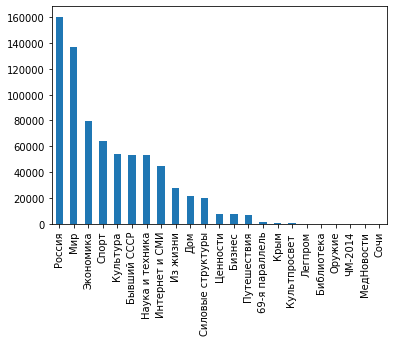

In [5]:
df["topic"].value_counts().plot(kind="bar")

Топовые темы - Россия, Мир, Экономика. Для нескольких редких категорий представлено буквально по несколько записей.

## Tags

In [8]:
df["tags"].nunique()

94

In [7]:
df["tags"].value_counts()

Все               453762
Политика           40716
Общество           35202
Украина            22523
Происшествия       19825
                   ...  
Мировой опыт           6
Нацпроекты             6
Вооружение             3
Инновации              1
69-я параллель         1
Name: tags, Length: 94, dtype: int64

Всего 94 тега. Кажется, для нашей задачи они не оч полезны.

# Моделирование

## Выбор темы

Для тематического моделирования выделим одну тему - "Наука и техника" и внутри неё будем искать подтемы.

In [9]:
df2 = df.query("topic == 'Наука и техника'")
df2.shape

(53136, 6)

In [10]:
df2.duplicated(subset="url").sum()

0

## Подготовка текстов

Теперь выполним токенизацию и лемматизацию текстов. Для этого будем использовать библиотеку [Spacy](https://spacy.io).
  Если выполнять обработку над каждым текстом по-отдельности, то это займёт достаточно много времени. Для ускорения применим "пакетную обработку" (batch processing).

Устанавливаем либу и качаем русскоязычную модель _ru_core_news_sm_.

In [12]:
! pip install spacy
! python -m spacy download ru_core_news_sm

     |████████████████████████████████| 6.8 MB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 928 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 9.2 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 4.3 MB/s eta 0:00:011
     |████████████████████████████████| 130 kB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 493 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 10.2 MB 1.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/frodos/.pyenv/versions/3.8.10/envs/ds/bin/python3.8 -m pip install --upgrade pip' command.
/home/frodos/.pyenv/versions/ds/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
     |█████

In [14]:
import spacy

/home/frodos/.pyenv/versions/3.8.10/envs/ds/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [15]:
model = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

Складываем все новости в один список

In [17]:
texts = df2["text"].tolist()

Выполняем лемматизацию текстов. Наберитесь терпения - это долгий процесс, который может занять около часа.

In [30]:
res = []
for doc in model.pipe(texts, disable=["tagger", "parser"]):
    res.append([token.lemma_ for token in doc])

In [32]:
with open("lemmas.json", "w") as fid:
    json.dump({"lemmas": res}, fid)

Сохраним результат, чтобы не повторять лемматизацию заново в следующий раз.

Смотрим на результат - случайным образом сэмплируем несколько примеров

In [40]:
", ".join(res[np.random.randint(len(res))])

'астронавт, роберт, бенкен, и, майк, фореман, в, пятница, рано, утро, по, московский, время, начать, четвёртый, выход, в, открытый, космос, с, мкс, в, рамка, текущий, миссия, ", индевора, ", ,,  , сообщать, риа, новость, ., по, слово, представитель, nasa, ,, астронавт, предстоять, испытательный, работа, по, ремонт, теплозащитный, слой, шаттл, -, при, помощь, специальный, пистолет, они, заполнить, раствор, повредить, теплозащитный, плитка, шаттл, ., После, испытание, тестовый, плитка, быть, возвратить, на, земля, на, проверка, и, изучение, ., также, в, ход, работа, в, открыть, космос, бенкен, и, фореман, заменить, сломанный, контрольный, модуль, электропитание, (, предохранитель, ), на, мкс, ., пятый, и, последний, для, этот, экипаж, ", индевора, ", выход, в, открытый, космос, запланировать, на, 01:23, воскресение, по, московский, время, .'

In [43]:
", ".join(res[np.random.randint(len(res))])

'дальность, применение, гиперзвуковой, ракета, авиационный, комплекс, ", кинжал, ", достигнуть, примерно, 3000, километр, с,  , ракетоносец, -, бомбардировщик, ту-22м3, ,, тогда, как, в, случай, истребитель, -, перехватчик, миг-31к, она, составлять, более, 2000, километр, ,, сообщить, тасс, источник, в, оборонно, -, промышленный, комплекс, ., собеседник, отметить, ,, что, дальность, применение, комплекс, ", кинжал, ", иметь, смысл, определять, как, сумма, боевой, радиус, действие, самолёт, -, носитель, (, обычно, в, два, раз, меньше, он, максимальный, дальность, ), и, собственный, дальность, ракета, ,, отсчитывать, непосредственно, после, она, пуск, с, носитель, ., ", Для, ту-22м3, ,, на, котором, в, близкий, время, быть, испытываться, ракета, ,, дальность, поражение, цель, гиперзвуковой, ракета, составить, более, 3000, километр, ", ,, —, сказать, источник, ., собеседник, отказаться, назвать, точный, собственный, дальность, ракета, комплекс, ", кинжал, ", ., источник, риа, новость, зая

In [44]:
", ".join(res[np.random.randint(len(res))])

'еврокомиссия, одобрить, сделка, по, приобретение, корпорация, microsoft, сервис, voip, -, телефония, skype, ,, передавать, в, пятница, agence, france, -, presse, со, ссылка, на, заявление, власть, евросоюз, ., как, говориться, в, заключение, комиссия, ,, сделка, не, помешать, конкуренция, на, европейский, рынок, частный, интернет, -, телефонии, и, не, ограничить, возможность, около, 500, миллион, европейский, пользователь, ., этот, рынок, продолжать, расти, и, на, нем, действовать, многочисленный, игрок, ,, в, тот, число, google, ,, отмечать, в, комиссия, ., что, касаться, рынок, корпоративный, коммуникация, ,, расследование, еврокомиссия, подтвердить, ,, что, skype, присутствовать, на, нем, в, ограничить, объём, и, не, конкурировать, напрямую, с, microsoft, lync, ,, которую, в, основный, использовать, крупный, компания, ., о, том, ,, что, microsoft, покупать, skype, за, 8,5, миллиард, доллар, ,, стать, известный, в, май, 2011, год, ,, когда, сделка, утвердить, член, совет, директор, 



Удалим знаки препинания, цифры и слова, содержащие цифры. Для это соберём регулярное выражение, которое подходит для любого слова, состоящего из букв кирилицы.



In [47]:
word_pattern = re.compile("^[а-я]*$")

In [50]:
def remove_symbols(doc):
    return [token for token in doc if word_pattern.match(token)]

In [55]:
corpus = list(map(remove_symbols, res))

In [56]:
", ".join(corpus[np.random.randint(len(corpus))])

'в, аргентина, откопать, скелет, двуногий, плотоядный, ящер, жить, около, миллион, год, назад, в, середина, юрский, период, сообщать, рост, хищник, при, жизнь, составлять, примерно, семь, метр, кость, ящер, были, найти, от, патагонский, деревушка, серро, кондор, в, это, место, палеонтологический, изыскание, вестись, уже, около, пять, год, один, из, найти, скелет, палеонтолог, заявить, агентство, что, с, этот, ящер, очень, повезти, так, как, останки, такой, возраст, крайне, редко, когда, находиться, в, такой, хороший, состояние, по, слово, на, полный, извлечение, скелет, ящер, из, земля, уйти, около, год'

Выглядит гораздо лучше.

## Векторизация текстов

Теперь необходимо перевести тексты новостей и слова, из которых они состоят, в числовое представление, т.е. провести векторизацию. Для этого можно использовать подход "мешок слов" (Bag of Words) или Tf-iDf. Второй вариант нравится мне больше. 

Чтобы уменьшить размерность получаемой матрицы, добавим исключение стоп-слов.

In [73]:
stop_words = stopwords.words('russian')
print(stop_words)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [114]:
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.9)

Т.е. TfIdfVectorizer принимает на вход список предложений, поэтому необходимо объединить списки слов, составляющих корпус, в предложения.

In [111]:
docs = [" ".join(tokens) for tokens in corpus]
docs[:3]

['американский в близкий время отправить на орбита спутник который проверить два фундаментальный предположение выдвинуть альберт эйнштейн в рамка общий теория относительность сообщать представитель и стенфордского университет в пятница рассказать о том что проект спутник разрабатываться с год с тот пора было провести несколько неудачный попытка старт и решить множество технический проблема наконец апрель спутник быть запустить с база ввс сша вандерберг аппарат создать с тем чтобы проверить высказать в теория относительность альберт эйнштейн предположение относительно пространственно временной закономерность любой физический процесс эксперимент касаться заявление о том что пространство и время искривляются в присутствие земля а вращение земля увлекать за себя пространство и время в основа аппарат четыре кварцевый сфера размер с мяч для пинг понг шар находиться в гироскоп и максимально изолировать от воздействие внешний среда в космос на полярный орбита они быть раскрутить ось вращение ш

In [115]:
x = tfidf.fit_transform(docs)

In [116]:
x.shape

(53136, 19826)

Теперь составим словарь {id_токена: токен} - он пригодится нам позднее.

In [120]:
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names())}

## LDA

Теперь можем запустить алгоритм LDA. Зададим количество тем равное 20.

In [144]:
n_topics = 20

In [149]:
lda = LatentDirichletAllocation(n_components=n_topics, random_state=31)

In [150]:
topics = lda.fit_transform(x)

In [151]:
topics.shape

(53136, 20)

Получили массив размера 53136x20. Строки здесь - отдельные тексты, а колонки - 20 выделенных тем. В каждой ячейке стоит вероятность того, что данный текст относится к данной теме. Это то самое распределение тем над документами.

### Ключевые слова

Теперь извлечём ключевые слова для каждой из 20 тем. В свойсте _components_ _ лежит матрица соответствия слов темам. Пройдёмся по каждой из 20 выделенных тем и для каждой возьмём ТОП-20 слов.

По очереди пройдёмся по каждой теме (первое измерение массиа) и выберем ТОП-20 слов, наиболее характерных для этой темы. Потом по индексу слова обратимся к словарю и узнаем, что это за слово.

In [155]:
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]]
    print("Тема",i+1, ":")
    print(", ".join(topic_tokens))
    print("\n ")

Тема 1 :
табличка, кларк, эллен, усыпальница, оорта, древнеегипетский, майлз, петрик, тутанхамона, троянов, египтянин, саркофаг, мумия, пирамида, египетский, гробница, литовский, египет, фараон, литва

 
Тема 2 :
блок, субмарина, носитель, вмф, фрегат, аппарат, орбита, космический, проект, год, космодром, пуск, запуск, флот, лодка, подлодка, подводный, спутник, корабль, ракета

 
Тема 3 :
вещество, группа, мозг, организм, опубликовать, автор, ген, животное, которые, университет, работа, результат, журнал, вода, человек, мочь, это, клетка, исследование, исследователь

 
Тема 4 :
процент, модель, представить, рынок, компьютер, версия, система, новый, доллар, продажа, мобильный, планшет, приложение, телефон, экран, год, пользователь, компания, смартфон, устройство

 
Тема 5 :
морж, античастица, позитрон, антикварк, подведомственный, нтс, грозовой, перец, копролит, антивещество, солитон, типчак, корсар, молния, мезон, клипер, тасс, итар, фано, интерфакс

 
Тема 6 :
новый, представить, ядро

По полученным ключевым словам можно составить представление о содержании той или иной темы. Хотя иногда сочетания слов довольно странные )  

### Типичные статьи

Теперь для каждой темы возьмём по одному документу, который хорошо соответсвует этой теме. Для этого заглянем в массив _topics_.

In [167]:
for i in range(n_topics):
    doc_id = np.argmax(topics[:, i])
    print("Тема ", i)
    print(df2.iloc[doc_id]["text"])
    print("\n")

Тема  0
Группа археологов из Египта обнаружила в районе Дахшур — некрополь фараонов Древнего и Среднего царств в Египте и в 26 километрах от Каира — руины ранее неизвестной древней пирамиды. Об этом заявили в министерстве по делам памятников древнего Египта, сообщает РИА Новости. По оценкам, пирамида была построена во времена XIII династии фараонов (XVIII — XVII века до нашей эры) и располагалась она к югу от знаменитой Ломаной пирамиды фараона Снофру. Также специалисты нашли обломок алебастровой таблички с иероглифическим текстом размером 17 на 15 сантиметров. «Обнаруженная часть находится в хорошем состоянии, археологическая миссия продолжит работы, надеясь обнаружить другие части пирамиды», — рассказал руководитель центрального управления министерства по Каиру и Гизе Аля аш-Шахат. На территории Дахшура всего было найдено 15 пирамид, которые относятся к IV, XII и XIII династиям фараонов. Лучше других сохранились Ломаная и Розовая пирамиды Снофру, при строительстве которых египтянам у

Типичные статьи, в целом хорошо согласуются с ключевыми словами, которые мы выделили. Например, первая выделенная тема - про египтологию и археологию. 
 В тоже время, мы видим и очень короткие тексты, например 4 и 14. Это подсказывает дальнейшие шаги. Например:
  - удалить из корпуса текстов очень короткие статьи. Чтобы правильно задать порог отсечения, необходимо построить распределение текстов по длине.   - возможно, ключевыми словами, на которые ориентировался алгоритм, стали названия информационных агентств - РБК и ИТАР-ТАСС. Стоит подумать о том, чтобы добавить эти слова в стоп-лист. 

А ещё вы всегда можете сделать шаг назад и дополнить модель. Например:
- пополнить список стоп-слов (просмотрите внимательно ключевые слова каждой из тем - нет ли там случайных слов?);
- изменить настройки Tf-idF;
- увеличить/уменьшить количество тем;
- обучать LDA чуть дольше;
- заменить LDA на другой алгоритм тематического моделирояни.

# Полезные ссылки

- [Вики](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)

- [История о том, как прочитать 120 тысяч анекдотов и не рассмеяться раньше времени](https://habr.com/ru/companies/otus/articles/723306/)

- [Видеоурок "Анализ текстовых данных тематическое моделирование комментариев Вконтакте"](https://www.youtube.com/watch?v=0DnfzQdbwQw)

- [LDA в Sklearn](https://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html)

- [Topic Modeling разными алгоритмами](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)

- [Более академическое описание тематического моделировния](http://www.machinelearning.ru/wiki/index.php?title=%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)